In [18]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from networkx.algorithms.community import girvan_newman
import infomap  # You need to install this: pip install infomap
import numpy as np

In [19]:
# Load dataset
dataset = load_dataset("RealTimeData/bbc_news_alltime", "2017-01")
texts = [item["content"] for item in dataset["train"] if item["content"]]


In [20]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts[:200], show_progress_bar=True)

Batches: 100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


In [21]:
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.5
G = nx.Graph()

for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [22]:
partition_louvain = community_louvain.best_partition(G, weight="weight")

clusters_louvain = {}
for node, comm in partition_louvain.items():
    clusters_louvain.setdefault(comm, []).append(texts[node])

In [23]:
gn_generator = girvan_newman(G)
first_level_communities = next(gn_generator)   # first split
partition_gn = {}
for comm_id, community_nodes in enumerate(first_level_communities):
    for node in community_nodes:
        partition_gn[node] = comm_id

clusters_gn = {}
for node, comm in partition_gn.items():
    clusters_gn.setdefault(comm, []).append(texts[node])


In [24]:
def run_infomap(graph):
    """Run Infomap algorithm on NetworkX graph"""
    im = infomap.Infomap("--two-level --directed")

    # Add nodes and edges to Infomap
    for node in graph.nodes():
        im.add_node(node)

    for edge in graph.edges(data=True):
        weight = edge[2].get('weight', 1.0)
        im.add_link(edge[0], edge[1], weight)

    # Run algorithm
    im.run()

    # Extract partition
    partition = {}
    for node in im.tree:
        if node.is_leaf:
            partition[node.node_id] = node.module_id

    return partition

In [25]:
partition_infomap = run_infomap(G)

clusters_infomap = {}
for node, comm in partition_infomap.items():
    clusters_infomap.setdefault(comm, []).append(texts[node])

  Infomap v2.8.0 starts at 2025-09-17 16:53:14
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    directed
  OpenMP 201511 detected with 1 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 60 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 89 nodes and 147 links...
  -> One-level codelength: 5.65969708

Trial 1/1 starting at 2025-09-17 16:53:14
Two-level compression: 46% 2% 
Partitioned to codelength 0.362542852 + 2.65000888 = 3.012551728 in 20 modules.

=> Trial 1/1 finished in 0.001110142s with codelength 3.01255173


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         20,           0] (sum: 20)
Per level number of leaf nodes:      [          0,          89] (sum: 89)
Per

In [26]:
def extract_keywords(clusters):
    community_keywords = {}
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    for comm, docs in clusters.items():
        if docs:  # Check if docs is not empty
            X = vectorizer.fit_transform(docs)
            scores = X.toarray().mean(axis=0)
            top_indices = scores.argsort()[-3:][::-1]  # Reduced to top 3 keywords
            keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
            community_keywords[comm] = ", ".join(keywords)
        else:
            community_keywords[comm] = "No keywords"
    return community_keywords

# Extract keywords for all algorithms
community_keywords_louvain = extract_keywords(clusters_louvain)
community_keywords_gn = extract_keywords(clusters_gn)
community_keywords_infomap = extract_keywords(clusters_infomap)

In [27]:
def create_better_layout(G, partition):
    """Create a layout that spreads communities better"""
    # Use force-directed layout with more iterations and better parameters
    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    # Post-process positions to spread communities further apart
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    # Calculate community centers and spread them out
    comm_centers = {}
    for comm, nodes in communities.items():
        if nodes:
            center_x = np.mean([pos[node][0] for node in nodes])
            center_y = np.mean([pos[node][1] for node in nodes])
            comm_centers[comm] = (center_x, center_y)

    # Spread community centers in a circle
    num_comms = len(comm_centers)
    if num_comms > 1:
        angles = np.linspace(0, 2*np.pi, num_comms, endpoint=False)
        radius = 3.0  # Increased radius for better separation

        for i, comm in enumerate(comm_centers.keys()):
            center_offset_x = radius * np.cos(angles[i])
            center_offset_y = radius * np.sin(angles[i])

            # Move all nodes in this community
            old_center = comm_centers[comm]
            for node in communities[comm]:
                pos[node] = (pos[node][0] - old_center[0] + center_offset_x,
                           pos[node][1] - old_center[1] + center_offset_y)

    return pos

In [28]:
pos_louvain = create_better_layout(G, partition_louvain)
pos_gn = create_better_layout(G, partition_gn)
pos_infomap = create_better_layout(G, partition_infomap)

In [29]:
plt.figure(figsize=(20, 8))

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

(np.float64(-4.4368821434334444),
 np.float64(4.569206519171665),
 np.float64(-4.358083313165919),
 np.float64(4.535128041377557))

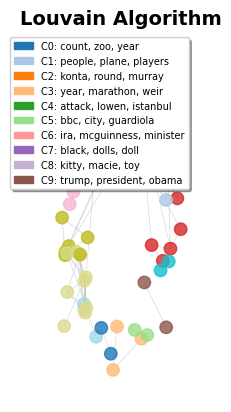

In [30]:
plt.subplot(1, 3, 1)
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos_louvain, node_size=80, node_color=colors, 
                       cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_louvain, alpha=0.3, width=0.5, edge_color='gray')

# Create legend with fewer, shorter labels
patches = []
for i in unique_comms[:min(10, len(unique_comms))]:  # Limit to 10 communities
    if i in community_keywords_louvain:
        keywords = community_keywords_louvain[i]
        # Truncate long keyword strings
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                                    label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Louvain Algorithm", fontsize=14, fontweight='bold')
plt.axis("off")

(np.float64(-4.675635756977691),
 np.float64(4.750059191482111),
 np.float64(-4.269515467129876),
 np.float64(4.322359173388305))

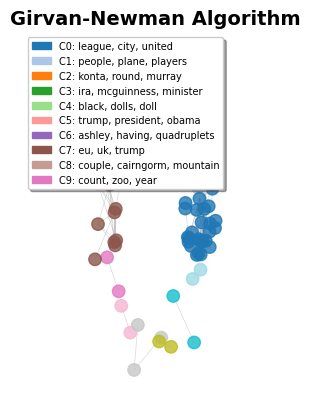

In [31]:
plt.subplot(1, 3, 2)
colors = [partition_gn[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos_gn, node_size=80, node_color=colors, 
                       cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_gn, alpha=0.3, width=0.5, edge_color='gray')

patches = []
for i in unique_comms[:min(10, len(unique_comms))]:
    if i in community_keywords_gn:
        keywords = community_keywords_gn[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                                    label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Girvan-Newman Algorithm", fontsize=14, fontweight='bold')
plt.axis("off")

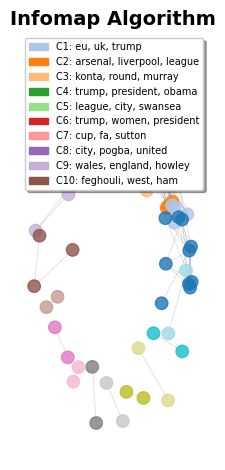

In [32]:
plt.subplot(1, 3, 3)
colors = [partition_infomap[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos_infomap, node_size=80, node_color=colors, 
                       cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G, pos_infomap, alpha=0.3, width=0.5, edge_color='gray')

patches = []
for i in unique_comms[:min(10, len(unique_comms))]:
    if i in community_keywords_infomap:
        keywords = community_keywords_infomap[i]
        if len(keywords) > 30:
            keywords = keywords[:27] + "..."
        patches.append(mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                                    label=f"C{i}: {keywords}"))

plt.legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), 
          fontsize=7, frameon=True, fancybox=True, shadow=True)
plt.title("Infomap Algorithm", fontsize=14, fontweight='bold')
plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()